In [20]:
import os
os.environ['MUJOCO_GL']='egl'
# load pickle file
import pickle
import jax 
import jax.numpy as jnp 
import numpy as np 
import optax 
import haiku as hk
import time
import tqdm 
import gymnasium as gym

with open('maze_rollouts.pkl', 'rb') as f:
    data = pickle.load(f)

rollouts = []
rollout = []
for t, transition in enumerate(data):
    obs_t, obs_tp1, action, rew, terminated, truncated, info = transition

    rollout.append((obs_t, action, rew, terminated, truncated, info))
    if terminated or truncated:
        rollouts.append(rollout)
        rollout = []
        
print("number of rollouts: ", len(rollouts))
print("average length of rollout: ", sum(len(r) for r in rollouts) / len(rollouts))

obs_data = []
for rollout in rollouts:
    obs = [step[0] for step in rollout]
    obs[0] = obs[0][0]
    obs = [o["observation"] for o in obs]
    # obs = [np.concatenate((o["observation"], o["desired_goal"])) for o in obs]
    obs_data.extend(obs[:-1])
obs_data = np.array(obs_data)
xy_data = obs_data[:, :2]
print("obs_data.shape: ", obs_data.shape, "xy_data.shape: ", xy_data.shape)
print(xy_data.min(axis=0), xy_data.max(axis=0 ))

import numpy as np
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape), kde_skl


number of rollouts:  41
average length of rollout:  341.3658536585366
obs_data.shape:  (13955, 4) xy_data.shape:  (13955, 2)
[-2.02338379 -2.23634314] [2.41149424 2.42139255]


In [9]:
print(100j)

100j


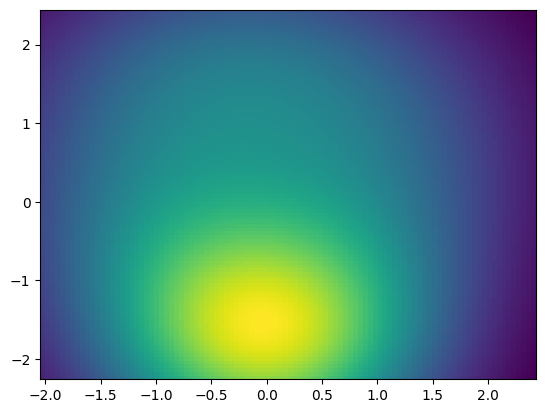

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# m1 = np.random.normal(size=1000)
# m2 = np.random.normal(scale=0.5, size=1000)

# x, y = m1 + m2, m1 - m2
# print(x.shape, y.shape)
# print(xy_data[:, :0].shape)
x, y = xy_data[:, 0], xy_data[:, 1]
xx, yy, zz, kde_skl = kde2D(x, y, 1)

plt.pcolormesh(xx, yy, zz)
# plt.scatter(x, y, s=20, facecolor='blue')
# plt.colorbar()
plt.show()

In [ ]:
xy_data[:, 0].min(), xy_data[:, 0].max(), xy_data[:, 1].min(), xy_data[:, 1].max()

In [13]:
# plot density vs variance 

# compute density for each point in the dataset
densities = np.exp(kde_skl.score_samples(xy_data))

In [23]:
obs_data.shape

(13955, 4)

In [35]:
hidden_size = 128
class ValueFn(hk.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

    def __call__(self, obs):
        input = hk.Flatten()(obs)
        v1 = hk.nets.MLP([self.hidden_size, self.hidden_size, 1])(input)
        v2 = hk.nets.MLP([self.hidden_size, self.hidden_size, 1])(input)
        return v1, v2
    
@hk.transform
def v_fn(obs):
    return ValueFn(hidden_size)(obs)

# load params 
with open('results/vf_params.pkl', 'rb') as f:
    vf_params = pickle.load(f)

# compute value variance for each point in the dataset
value_estimates = jax.vmap(lambda params: hk.without_apply_rng(v_fn).apply(params, obs_data))(vf_params)
v1, v2 = value_estimates
value_estimate = jnp.minimum(v1, v2)
value_variances = jnp.var(value_estimate, axis=0)

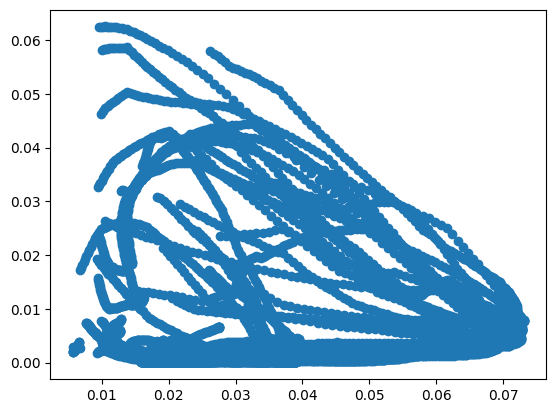

In [ ]:
plt.scatter(densities, value_variances)
plt.xlabel('Density')
plt.ylabel('Value Variance')